In [3]:
# Librerias 
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
import matplotlib.pyplot as plt


In [4]:

# Carga de datos
df = pd.read_csv('Data.csv') 
stations = pd.read_csv('stations.csv')  

# Merge de data
df = df.merge(stations, left_on='Ciclo_Estacion_Retiro', right_on='id', how='left')
df.rename(columns={'lat': 'Lat_Retiro', 'lon': 'Lon_Retiro'}, inplace=True)
df = df.merge(stations, left_on='Ciclo_Estacion_Arribo', right_on='id', how='left')
df.rename(columns={'lat': 'Lat_Arribo', 'lon': 'Lon_Arribo'}, inplace=True)
df.drop(['id_x', 'id_y'], axis=1, inplace=True)  


C:\Users\denis\AppData\Local\Temp\ipykernel_30036\2936948048.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Data.csv')


In [5]:
df.isna().sum() 

Genero_Usuario             0
Edad_Usuario               0
Bici                       0
Ciclo_Estacion_Retiro      0
Fecha_Retiro               0
Hora_Retiro                0
Ciclo_Estacion_Arribo      0
Fecha_Arribo               0
Hora_Arribo                0
Lat_Retiro                 9
Lon_Retiro                 9
name_x                     9
Lat_Arribo               158
Lon_Arribo               158
name_y                   158
dtype: int64

In [6]:
df = df.dropna()
df.drop('name_y', axis=1, inplace=True)
df.rename(columns={'name_x': 'name'}, inplace=True)
df.isna().sum()

Genero_Usuario           0
Edad_Usuario             0
Bici                     0
Ciclo_Estacion_Retiro    0
Fecha_Retiro             0
Hora_Retiro              0
Ciclo_Estacion_Arribo    0
Fecha_Arribo             0
Hora_Arribo              0
Lat_Retiro               0
Lon_Retiro               0
name                     0
Lat_Arribo               0
Lon_Arribo               0
dtype: int64

In [7]:

# Convertir las columnas de tiempo a datetime
df['Tiempo_Retiro'] = pd.to_datetime(df['Fecha_Retiro'] + ' ' + df['Hora_Retiro'])
df['Tiempo_Arribo'] = pd.to_datetime(df['Fecha_Arribo'] + ' ' + df['Hora_Arribo'])
df['Duracion'] = (df['Tiempo_Arribo'] - df['Tiempo_Retiro']).dt.total_seconds() / 60

# Calculamos métricas por estación de retiro
df_features = df.groupby('Ciclo_Estacion_Retiro').agg({
    'Duracion': ['mean', 'count'],
    'Edad_Usuario': ['mean'],
    'Lat_Retiro': 'first',  
    'Lon_Retiro': 'first'
}).reset_index()

# Preparamos matriz
df_features.columns = ['Estacion', 'Duracion_Promedio', 'Total_Usos', 'Edad_Promedio', 'Latitud', 'Longitud']
features_matrix = df_features.iloc[:, 1:] 


### PCA

In [8]:
features_matrix

,Duracion_Promedio,Total_Usos,Edad_Promedio,Latitud,Longitud
0,12.871396,14357,35.275197,19.433571,-99.167809
1,13.014835,4631,35.340315,19.431386,-99.171695
2,16.013270,5343,34.406326,19.431655,-99.158668
3,14.219368,3332,34.297119,19.428309,-99.171713
4,14.390796,4750,34.752211,19.429720,-99.169363
...,...,...,...,...,...
475,16.911773,5150,32.746214,19.442127,-99.184433
476,19.027064,2031,31.948794,19.440905,-99.181743
477,14.817566,2409,33.879618,19.440818,-99.176961
478,19.774739,1055,34.497630,19.444433,-99.179664


In [9]:
X = features_matrix.values
X

array([[ 1.28713961e+01,  1.43570000e+04,  3.52751968e+01,
         1.94335714e+01, -9.91678091e+01],
       [ 1.30148348e+01,  4.63100000e+03,  3.53403153e+01,
         1.94313860e+01, -9.91716950e+01],
       [ 1.60132697e+01,  5.34300000e+03,  3.44063260e+01,
         1.94316550e+01, -9.91586680e+01],
       ...,
       [ 1.48175661e+01,  2.40900000e+03,  3.38796181e+01,
         1.94408180e+01, -9.91769610e+01],
       [ 1.97747393e+01,  1.05500000e+03,  3.44976303e+01,
         1.94444330e+01, -9.91796640e+01],
       [ 1.65871134e+01,  2.71600000e+03,  3.19668630e+01,
         1.94460730e+01, -9.91816540e+01]])

In [10]:
mu = X.mean(axis=0)
mu

array([  17.1208125 , 3379.58333333,   34.0878132 ,   19.40964677,
        -99.17091768])

In [11]:
sig = X.std(axis=0)
sig

array([2.08025943e+01, 2.26913993e+03, 1.02922150e+00, 2.43997578e-02,
       1.58089128e-02])

In [12]:
# Centrar 
Xc = (X - mu) / sig

In [13]:
Xc.mean(axis=0) 

array([ 1.60982339e-16, -5.92118946e-17,  1.43588845e-15, -1.81780517e-14,
       -1.08992815e-12])

In [14]:
Xc.std(axis=0) 

array([1., 1., 1., 1., 1.])

In [15]:
U, S, V = np.linalg.svd(Xc)

In [16]:
print(np.round(V.T, 2))

[[-0.07  0.28 -0.9  -0.3  -0.15]
 [ 0.61  0.33  0.26 -0.32 -0.59]
 [ 0.39 -0.53 -0.33  0.58 -0.36]
 [ 0.55  0.46 -0.11  0.36  0.58]
 [ 0.42 -0.56 -0.08 -0.59  0.4 ]]


In [17]:
X2 = Xc @ (V[:2,:].T)     
X2.shape

(480, 2)

In [18]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(features_matrix)

# Las cargas de las componentes principales
cargas = pca.components_
print(cargas)


[[-5.39610262e-04  9.99999854e-01 -2.56619276e-06  4.23235966e-06
   7.28265104e-07]
 [ 9.99998453e-01  5.39604656e-04 -1.66695282e-03  1.45658340e-04
  -6.18544760e-05]]


In [19]:
features_matrix.head(5)

,Duracion_Promedio,Total_Usos,Edad_Promedio,Latitud,Longitud
0,12.871396,14357,35.275197,19.433571,-99.167809
1,13.014835,4631,35.340315,19.431386,-99.171695
2,16.013270,5343,34.406326,19.431655,-99.158668
3,14.219368,3332,34.297119,19.428309,-99.171713
4,14.390796,4750,34.752211,19.429720,-99.169363


<Figure size 640x480 with 0 Axes>

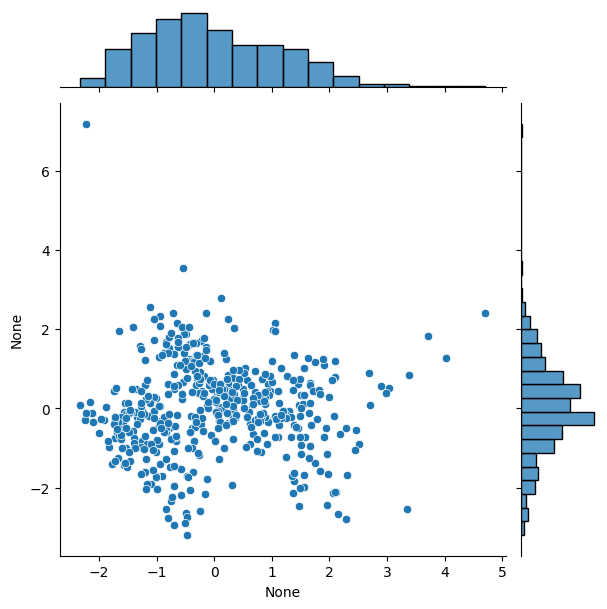

In [20]:
import seaborn as sns

plt.figure()
sns.jointplot(x=X2[:,0], y=X2[:,1], kind='scatter')
plt.show()

### MDS

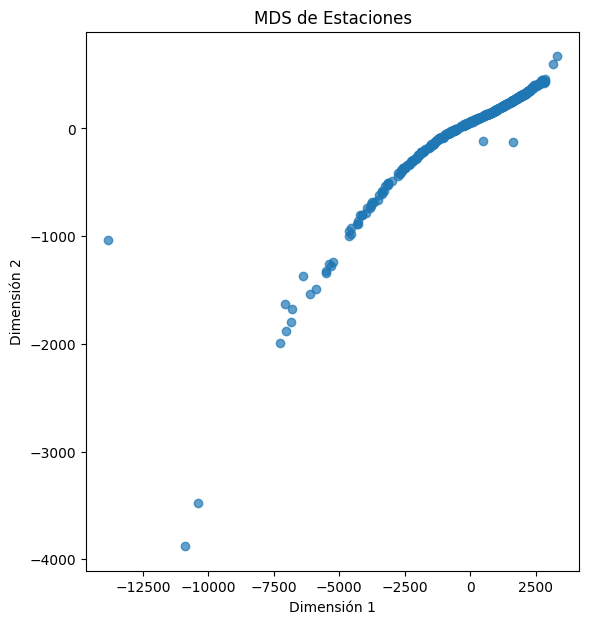

In [21]:
# MDS
from sklearn.manifold import MDS
mds = MDS(n_components=2)
mds_result = mds.fit_transform(features_matrix)

# Visualización
plt.figure(figsize=(14, 7))

# Gráfico de MDS
plt.subplot(1, 2, 2)
plt.scatter(mds_result[:, 0], mds_result[:, 1], alpha=0.7)
plt.title('MDS de Estaciones')
plt.xlabel('Dimensión 1')
plt.ylabel('Dimensión 2')

plt.show()


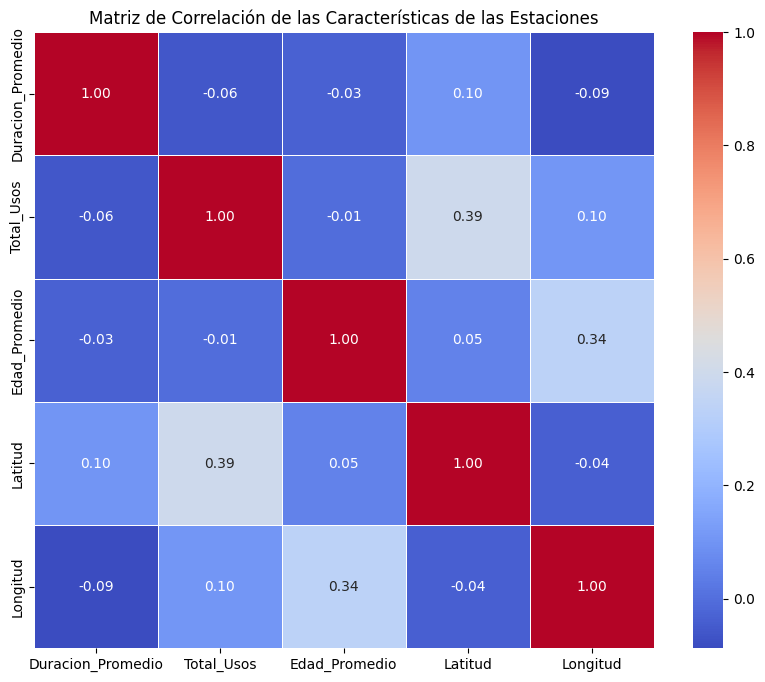

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt


# Calcular la matriz de correlación
correlation_matrix = features_matrix.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlación de las Características de las Estaciones')
plt.show()


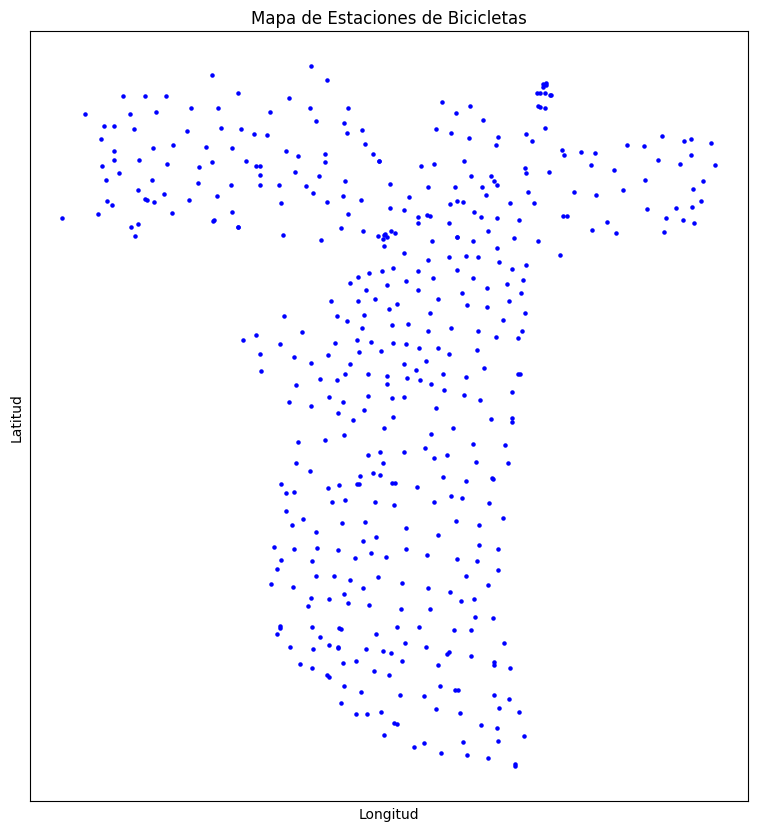

In [23]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Suponiendo que data_features es tu DataFrame y tiene 'Latitud' y 'Longitud'
# Convertir DataFrame en GeoDataFrame
geometry = [Point(xy) for xy in zip(features_matrix['Longitud'], features_matrix['Latitud'])]
geo_df = gpd.GeoDataFrame(features_matrix, geometry=geometry)

# Crear una figura y un eje
fig, ax = plt.subplots(figsize=(10, 10))
geo_df.plot(ax=ax, marker='o', color='blue', markersize=5)
ax.set_title('Mapa de Estaciones de Bicicletas')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')

# Omitir los ejes para un look más minimalista
ax.set_xticks([])
ax.set_yticks([])

# Mostrar el mapa
plt.show()
